# **Lesson 11**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params
%matplotlib inline

# The Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

# Exercise 11.1

We start by considering the linear fit of the following funtion:
$$
f(x)=2x+1
$$

In order to make practice with NN, explore how does the linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$.

In [3]:
# random seed
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
# parameters to vary
n_train_data = [500, 1000, 2000, 3000]
n_epochs = [10, 30, 50, 100]
sigmas = [0, 0.25, 0.5, 1]

# target model parameters
m_target = 2
q_target = 1

# validation dataset
n_valid_data = 70
x_valid = np.random.uniform(-1, 1, n_valid_data)
x_valid.sort()

y_target = m_target * x_valid + q_target

In [5]:
# store data
l_data = len(n_train_data)
l_sigm = len(sigmas)
l_epoc = len(n_epochs)

train_loss_1 = np.zeros((l_data, l_sigm, l_epoc, max(n_epochs)))
valid_loss_1 = np.zeros((l_data, l_sigm, l_epoc, max(n_epochs)))
m_model = np.zeros((l_data, l_sigm, l_epoc))
q_model = np.zeros((l_data, l_sigm, l_epoc))

In [6]:
def training_nn(x_train, y_train, x_valid, y_valid, n_epochs) :
    # initialize the neural network
    NN = tf.keras.Sequential()
    NN.add(Dense(1, input_shape=(1,)))
    NN.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    NN.summary()
    
    # fit the model
    story = NN.fit(x=x_train, y=y_train, batch_size=32, epochs=n_epochs, shuffle=True, validation_data=(x_valid, y_valid))

    m_model = NN.get_weights()[0][0][0]
    q_model = NN.get_weights()[1][0]
    train_loss = np.array(story.history['loss'])
    valid_loss = np.array(story.history['val_loss'])

    return m_model, q_model, train_loss, valid_loss


In [7]:
# loop over the parameters and train the model
for d, dat in enumerate(n_train_data) : 
    x_train = np.random.uniform(-1, 1, dat)
    for s, sigma in enumerate(sigmas) :
        y_train = np.random.normal(m_target * x_train + q_target, sigma)
        y_valid = np.random.normal(m_target * x_valid + q_target, sigma)
        for e, epo in enumerate(n_epochs) :
            output = training_nn(x_train, y_train, x_valid, y_valid, epo)
            m_model[d,s,e] = output[0]
            q_model[d,s,e] = output[1]
            train_loss_1[d,s,e,:epo] = output[2]
            valid_loss_1[d,s,e,:epo] = output[3]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 1s 30ms/step - loss: 4.1888 - mse: 4.1888 - val_loss: 3.3156 - val_mse: 3.3156
Epoch 2/10
16/16 [==============================] - 0s 11ms/step - loss: 3.1556 - mse: 3.1556 - val_loss: 2.5177 - val_mse: 2.5177
Epoch 3/10
16/16 [==============================] - 0s 14ms/step - loss: 2.4181 - mse: 2.4181 - val_loss: 1.9499 - val_mse: 1.9499
Epoch 4/10
16/16 [==============================] - 0s 17ms/step - loss: 1.8814 - mse: 1.8814 - val_loss: 1.5296 - val_mse: 1.5296
Epoch 5/10
16/16 [============

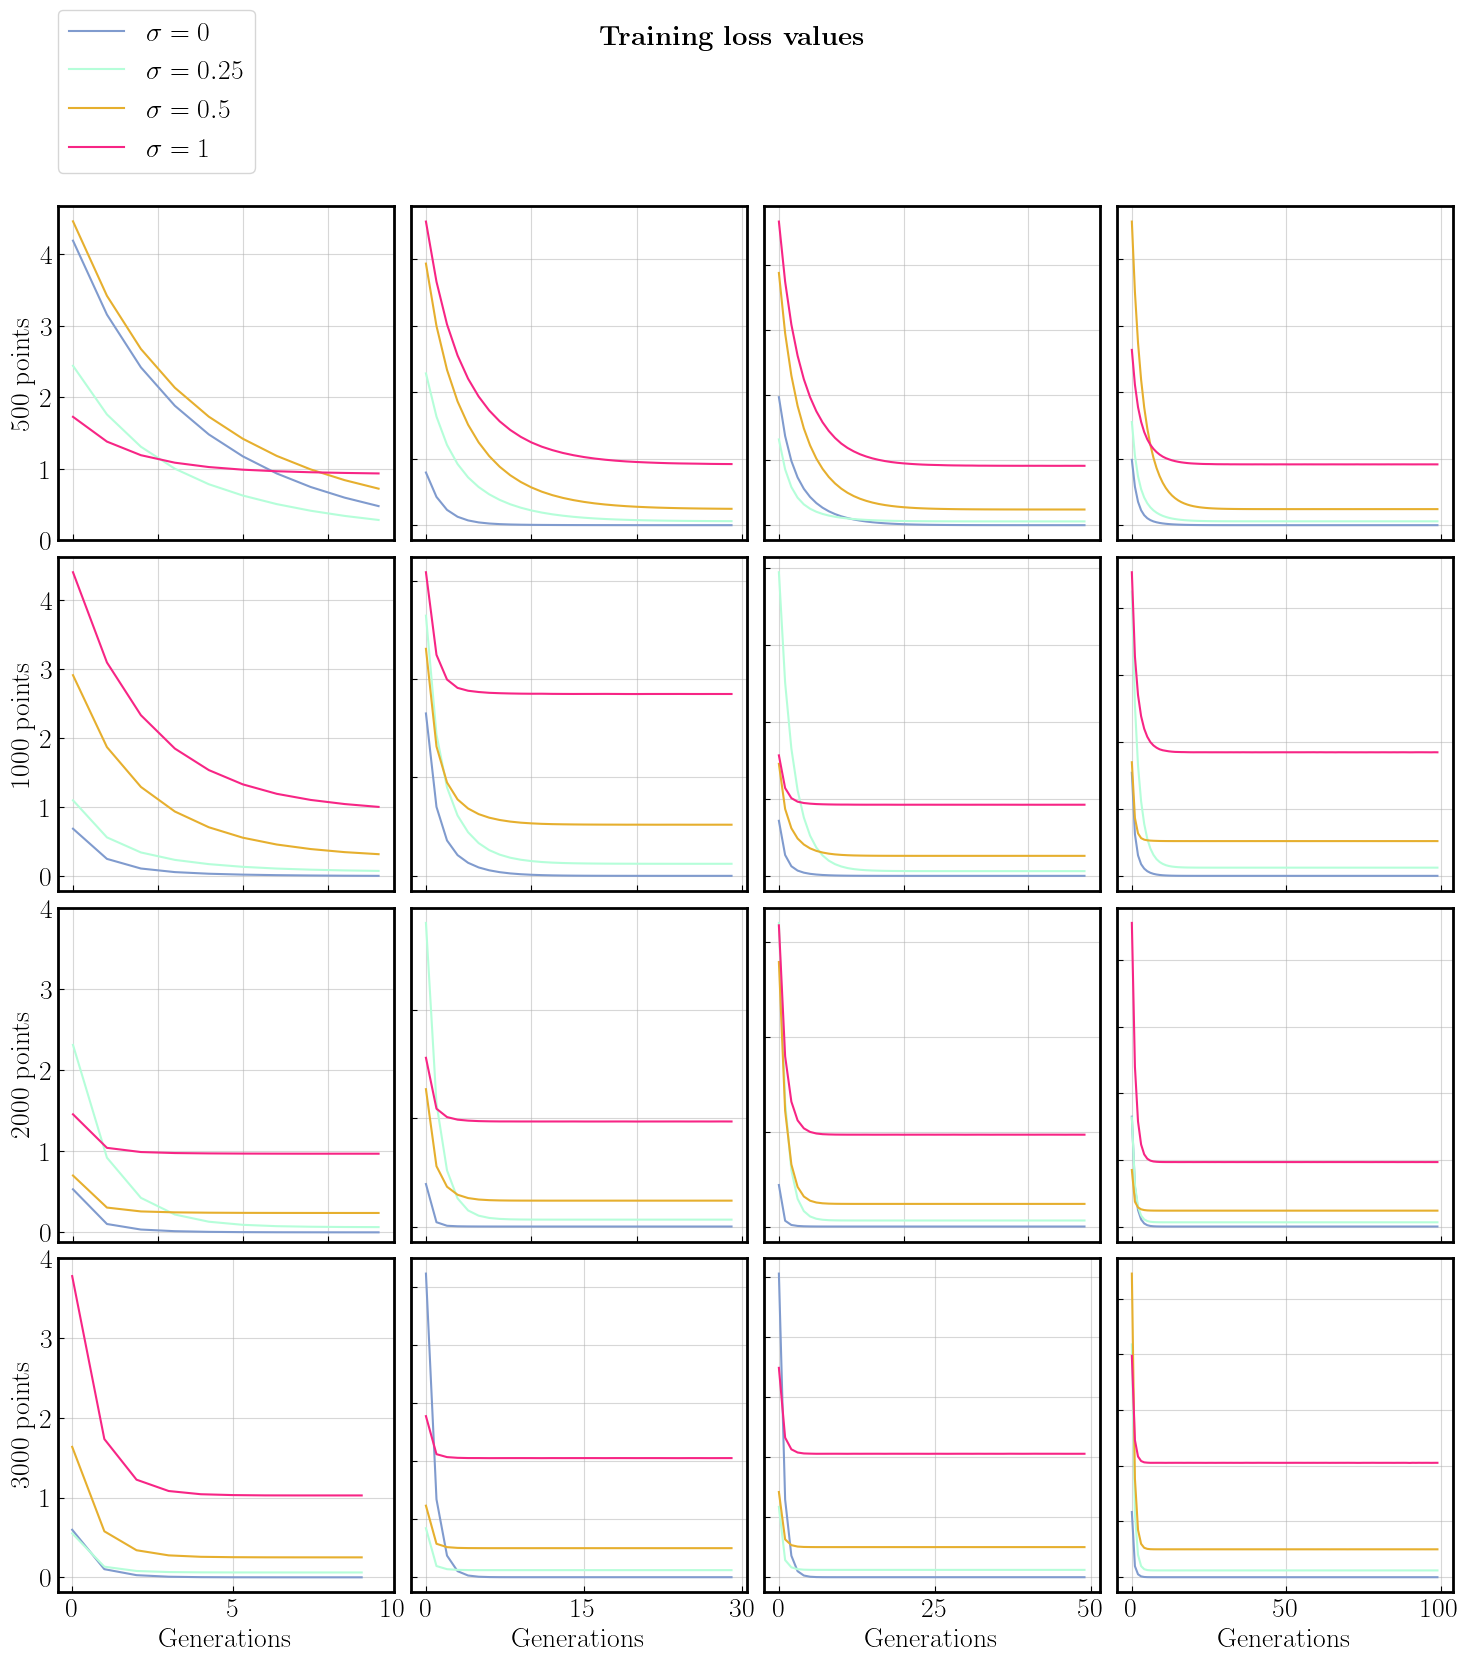

In [8]:
# plot the train losses
fig, axs = plt.subplots(4, 4, figsize=(18, 18), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
plt.suptitle(r'\textbf{Training loss values}')
colors = ['#809BCE', '#B5FED9', '#E6AF2E', '#F72585']

for d, dat in enumerate(n_train_data) : 
    for e, epo in enumerate(n_epochs) :
        x = np.linspace(1, epo, epo)
        for s, sigma in enumerate(sigmas) :
            axs[d,e].plot(train_loss_1[d,s,e,:epo], c=colors[s], label='$\sigma = ' + str(sigma) + '$')
        
        if(d != l_data-1) :
            axs[d,e].set_xticklabels([])
        axs[d,0].set_yticks([0,1,2,3,4], ['0', '1', '2', '3', '4'])
        if(e != 0) :
            axs[d,e].set_yticklabels([])
        axs[-1,e].set_xlabel('Generations')
    axs[d,0].set_ylabel(str(dat) + ' points')
            
axs[0,0].legend(loc=(0,1.1))
axs[-1,0].set_xticks([0,5,10], ['0','5','10'])
axs[-1,1].set_xticks([0,15,30], ['0','15','30'])
axs[-1,2].set_xticks([0,25,50], ['0','25','50'])


plt.show()

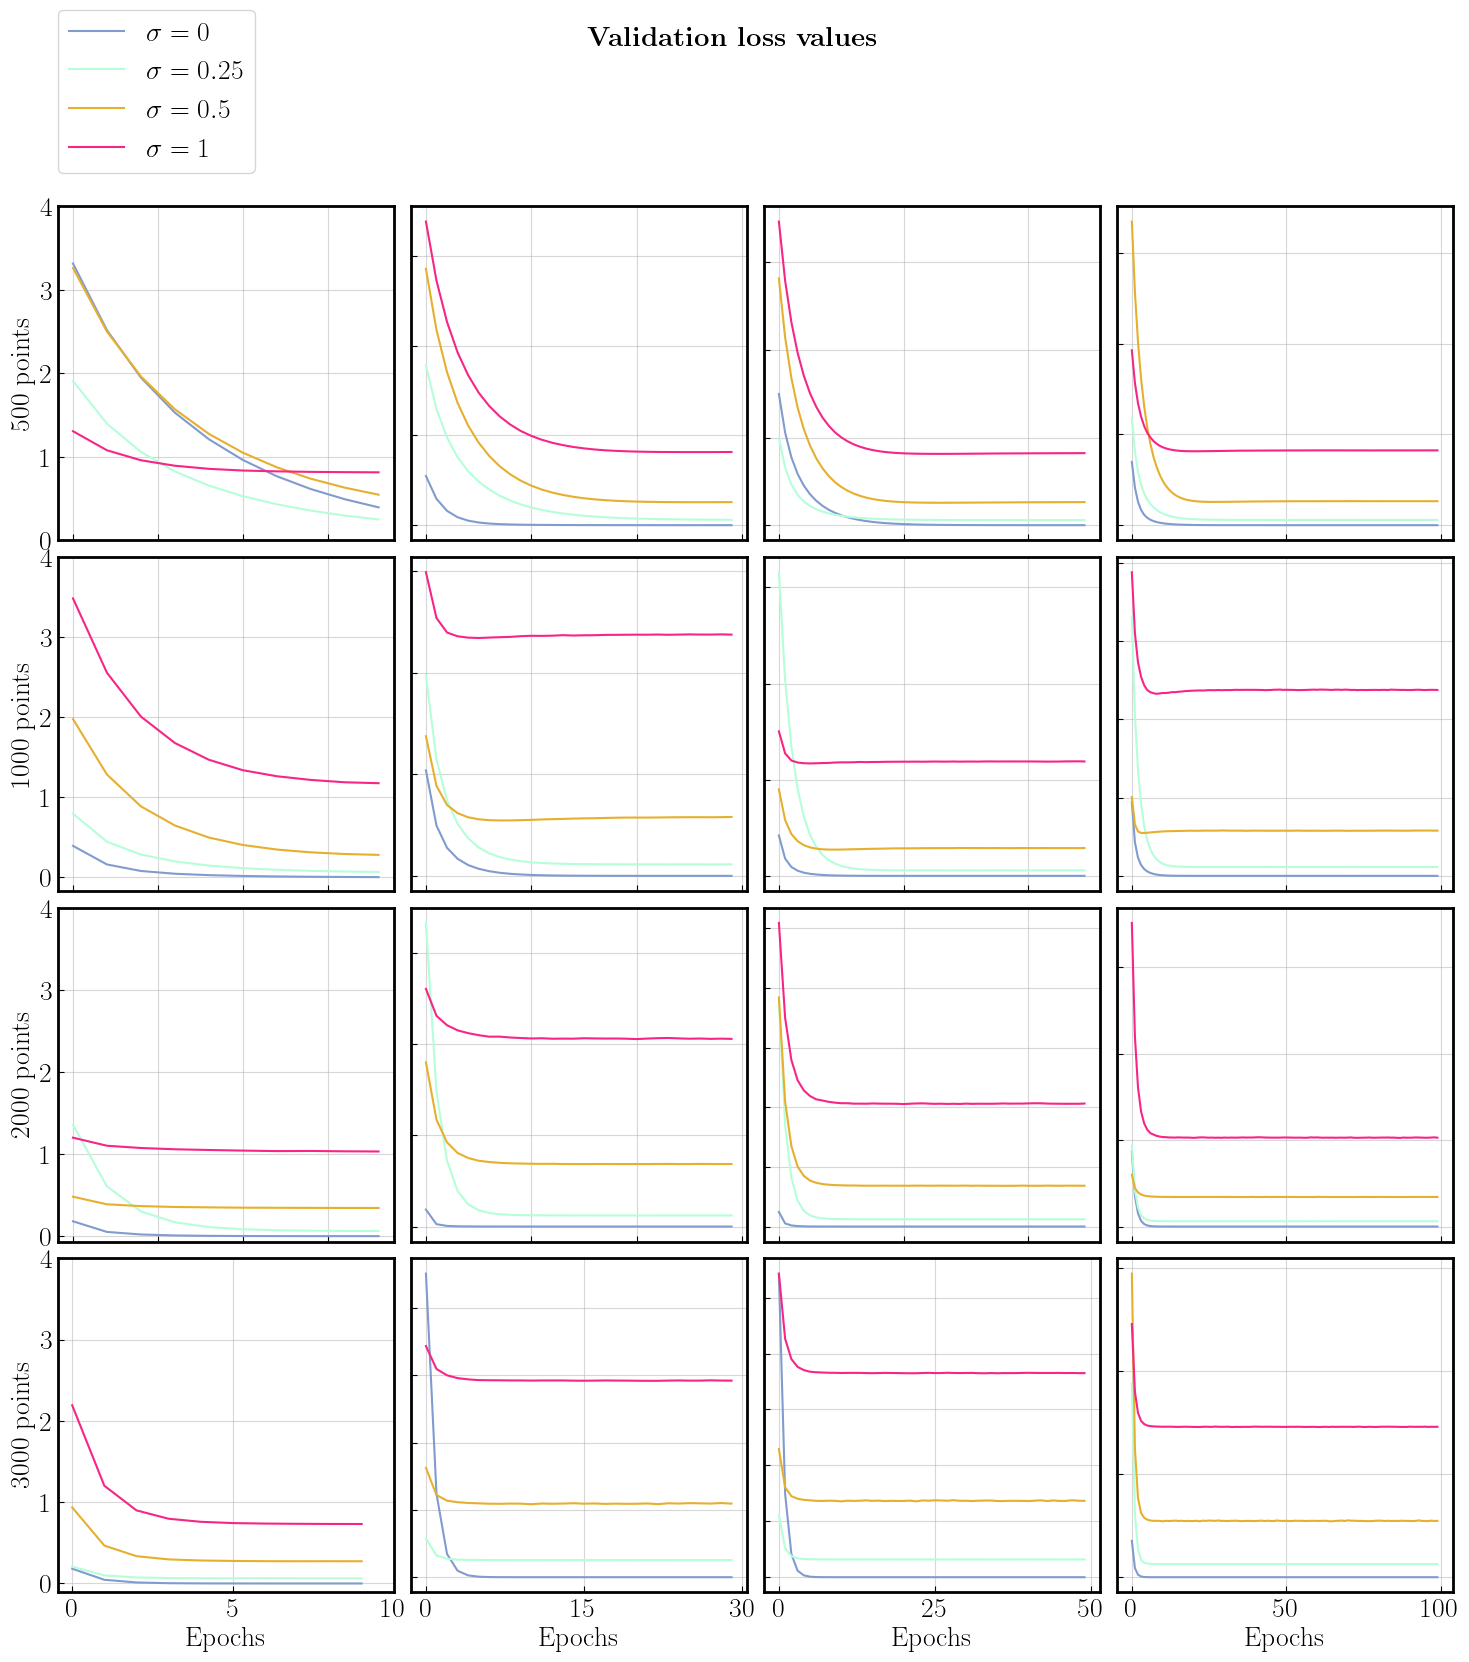

In [9]:
# plot the validation losses
fig, axs = plt.subplots(4, 4, figsize=(18, 18), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
plt.suptitle(r'\textbf{Validation loss values}')
colors = ['#809BCE', '#B5FED9', '#E6AF2E', '#F72585']

for d, dat in enumerate(n_train_data) : 
    for e, epo in enumerate(n_epochs) :
        x = np.linspace(1, epo, epo)
        for s, sigma in enumerate(sigmas) :
            axs[d,e].plot(valid_loss_1[d,s,e,:epo], c=colors[s], label='$\sigma = ' + str(sigma) + '$')
        
        if(d != l_data-1) :
            axs[d,e].set_xticklabels([])
        axs[d,0].set_yticks([0,1,2,3,4], ['0', '1', '2', '3', '4'])
        if(e != 0) :
            axs[d,e].set_yticklabels([])
        axs[-1,e].set_xlabel('Epochs')
    axs[d,0].set_ylabel(str(dat) + ' points')
            
axs[0,0].legend(loc=(0,1.1))
axs[-1,0].set_xticks([0,5,10], ['0','5','10'])
axs[-1,1].set_xticks([0,15,30], ['0','15','30'])
axs[-1,2].set_xticks([0,25,50], ['0','25','50'])


plt.show()

In [10]:
losses = [train_loss_1, valid_loss_1]

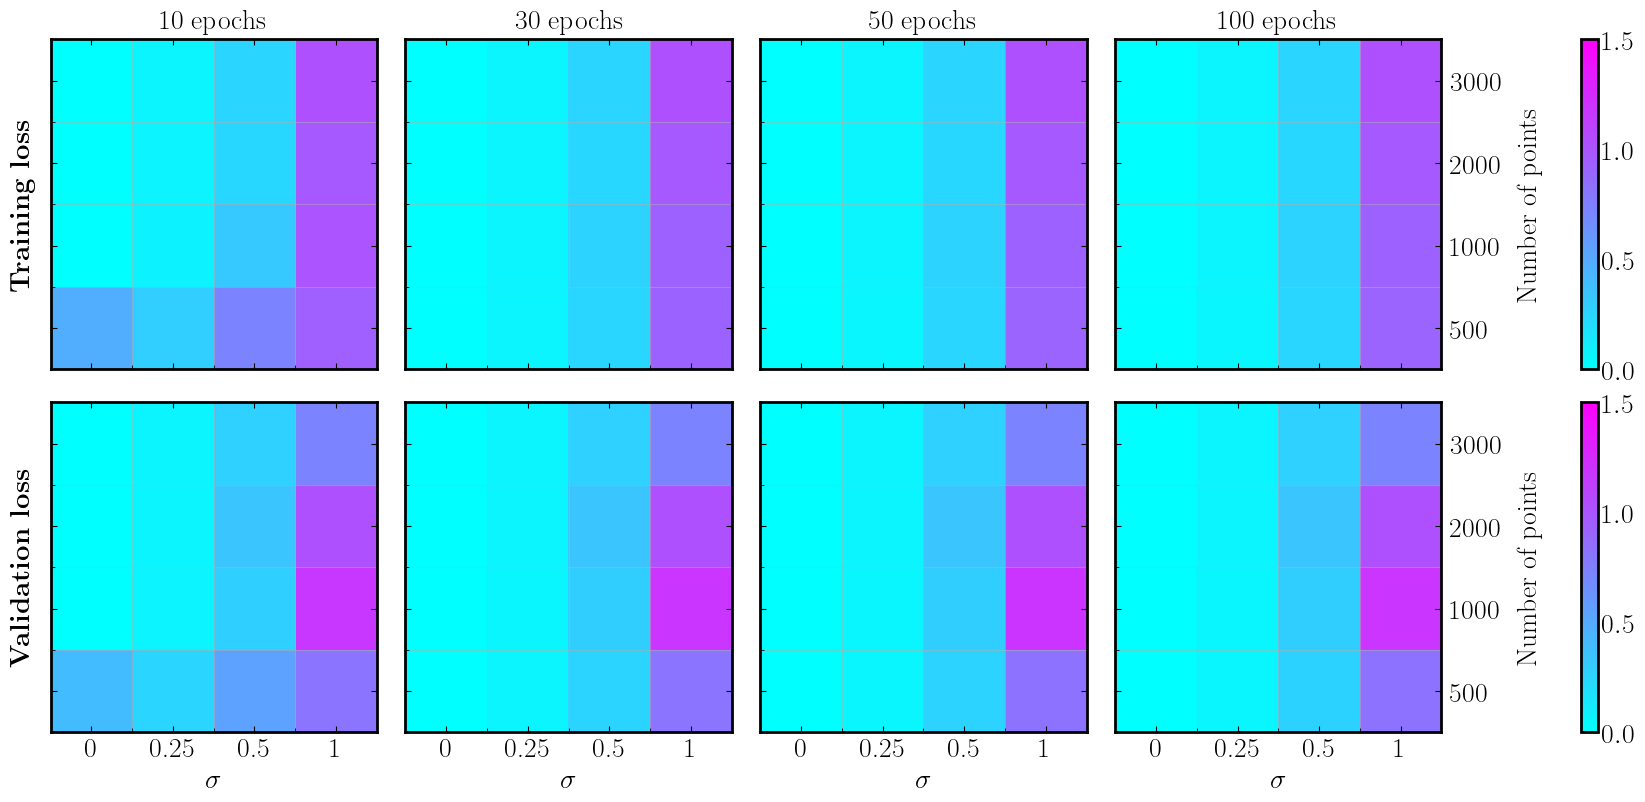

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(20,9), gridspec_kw={'hspace': 0.1, 'wspace': 0.1, 'width_ratios': [1, 1, 1, 1, 0.4]})

for i in range(2) :
    for e, epo in enumerate(n_epochs) :
        map = axs[i,e].imshow(losses[i][:,:,e,epo-1], origin='lower', cmap='cool', aspect='auto')
        map.set_clim(0,1.5)

        axs[1,e].set_xlabel('$\sigma$')
        axs[0,e].set_title(str(epo) + ' epochs', pad=8)
        axs[0,e].set_xticks([0,1,2,3], [])
        axs[1,e].set_xticks([0,1,2,3], sigmas)
        axs[i,e].set_yticklabels([])
        axs[i,e].yaxis.set_tick_params(right=True)
        axs[i,e].xaxis.set_tick_params(top=True)
        axs[i,e].minorticks_on()
        axs[i,e].set_xticks([0.5,1.5,2.5], minor=True)
        axs[i,e].set_yticks([0.5,1.5,2.5], minor=True)
        axs[i,e].grid(False, which='major')
        axs[i,e].grid(True, which='minor')
        axs[i,e].set_yticks([0,1,2,3], [])
    axs[i,3].set_yticks([0,1,2,3], n_train_data)
    axs[i,3].yaxis.set_tick_params(pad=6, labelleft=False, labelright=True)
    axs[i,3].set_ylabel('Number of points', labelpad=12)
    axs[i,3].yaxis.set_label_position('right')
    axs[i,4].axis('off')
    cbar = fig.colorbar(map, ax=axs[i,-1], location='right')

axs[0,0].set_ylabel(r'\textbf{Training loss}', labelpad=8)
axs[1,0].set_ylabel(r'\textbf{Validation loss}', labelpad=8)


plt.show()

# Exercise 11.2

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

Find good (& reasonable) choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Check your NN model by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

In [12]:
# target function
def poly3(x, a = 3, b = -2, c = -3, d = 4) :
    return a*(x**3) + b*(x**2) + c*x + d

# sigma and epochs
sigma = 0.4
epochs = 100

# training dataset
n_train = 1000
x_train = np.random.uniform(-1,1,n_train)
y_train = np.random.normal(poly3(x_train), sigma)

# validation dataset
n_valid = 100
x_valid = np.random.uniform(-1,1,n_valid)
x_valid.sort()
y_valid = np.random.normal(poly3(x_valid), sigma)

# dataset for a prediction
n_pred = 100
x_pred = np.random.uniform(-2,2,n_pred)
x_pred.sort()

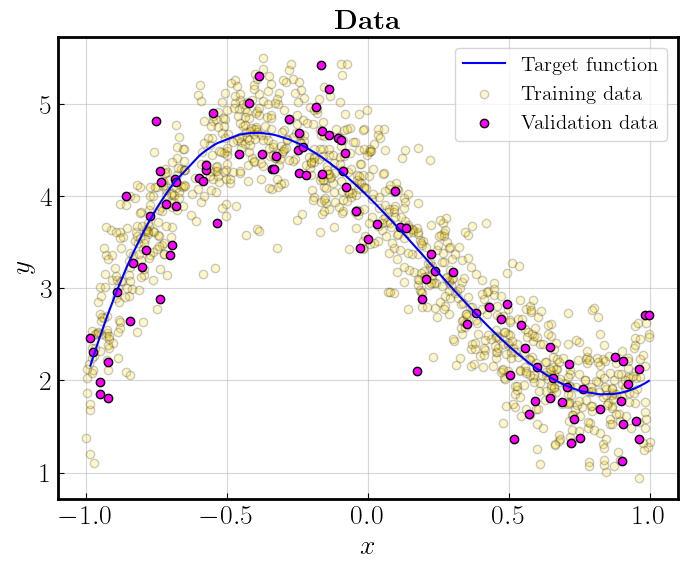

In [13]:
plt.plot(x_valid, poly3(x_valid), c='b', label='Target function')
plt.scatter(x_train, y_train, c='gold', alpha=0.2, label='Training data')
plt.scatter(x_valid, y_valid, c='magenta', label='Validation data')

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'\textbf{Data}')
plt.legend(fontsize=15)

plt.show()

In [14]:
# hyperparameters of the neural network: activation function, number of hidden layers, number of nodes per layer
activ = ['relu', 'elu', 'tanh']
layers = [2, 3]
neurons = [32, 64, 128]

l_act = len(activ)
l_lay = len(layers)
l_neu = len(neurons)

In [15]:
train_loss_2 = np.zeros((l_act, l_lay, l_neu, epochs))
valid_loss_2 = np.zeros((l_act, l_lay, l_neu, epochs))
prediction_2 = np.zeros((l_act, l_lay, l_neu, n_pred))

In [16]:
def training_hyparams(activ, layers, neurons) :
    # initialize the neural network
    NN = tf.keras.Sequential()
    for l in range(layers) :
        if(l == 0) :
            NN.add(Dense(neurons, input_shape=(1,), activation=activ))
        else :
            NN.add(Dense(neurons, activation=activ))
    NN.add(Dense(1, activation=activ))
    NN.compile(optimizer='adam', loss='mse', metrics=['mse'])
    NN.summary()
    
    # fit the model
    story = NN.fit(x=x_train, y=y_train, batch_size=32, epochs=epochs, shuffle=True, validation_data=(x_valid, y_valid))

    y_pred = np.array(NN.predict(x_pred))[:,0]
    train_loss = np.array(story.history['loss'])
    valid_loss = np.array(story.history['val_loss'])

    return y_pred, train_loss, valid_loss

In [17]:
# cycle over the hyperparameters
for a, act in enumerate(activ) :
    for l, lay in enumerate(layers) :
        for n, neu in enumerate(neurons) :
            prediction_2[a,l,n], train_loss_2[a,l,n], valid_loss_2[a,l,n] = training_hyparams(act, lay, neu)

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 32)                64        
                                                                 
 dense_65 (Dense)            (None, 32)                1056      
                                                                 
 dense_66 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 0s 6ms/step - loss: 10.9138 - mse: 10.9138 - val_loss: 8.9967 - val_mse: 8.9967
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 7.8750 - mse: 7.8750 - val_loss: 5.3261 - val_mse: 5.3261
Epoch 3/100
32/32 [==

In [18]:
losses = [train_loss_2, valid_loss_2]

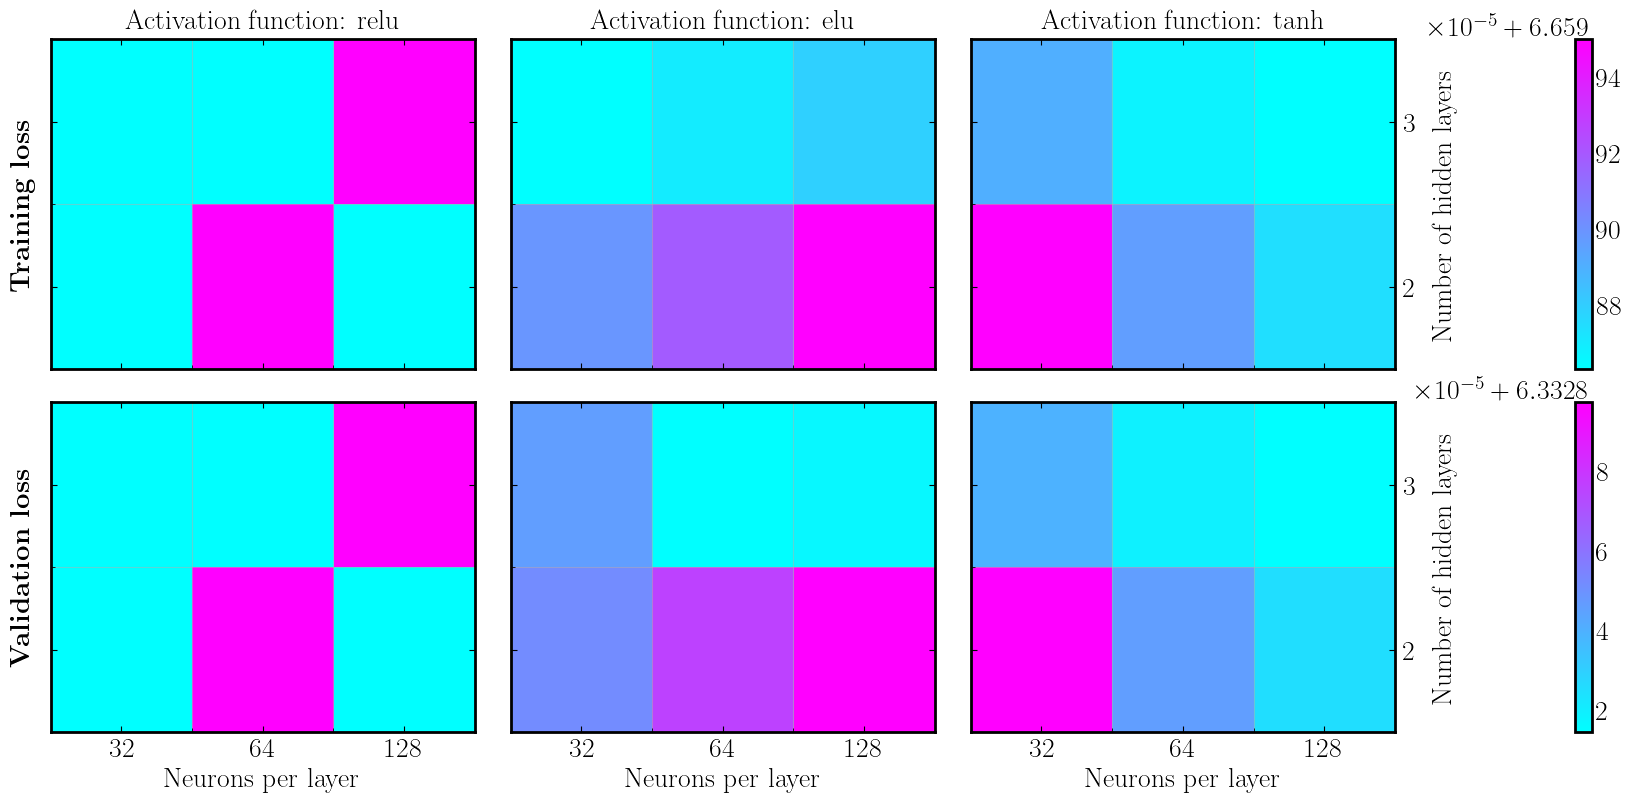

In [19]:
fig, axs = plt.subplots(2, l_act+1, figsize=(20,9), gridspec_kw={'hspace': 0.1, 'wspace': 0.1, 'width_ratios': [1, 1, 1, 0.4]})

for i in range(2) :
    for a, act in enumerate(activ) :
        map = axs[i,a].imshow(losses[i][a,:,:,-1], origin='lower', cmap='cool', aspect='auto')
        #map.set_clim(0,1.5)

        axs[1,a].set_xlabel('Neurons per layer')
        axs[0,a].set_title('Activation function: ' + act, pad=8)
        axs[0,a].set_xticks([0,1,2], [])
        axs[1,a].set_xticks([0,1,2], neurons)
        axs[i,a].set_yticklabels([])
        axs[i,a].yaxis.set_tick_params(right=True)
        axs[i,a].xaxis.set_tick_params(top=True)
        axs[i,a].minorticks_on()
        axs[i,a].set_xticks([0.5,1.5], minor=True)
        axs[i,a].set_yticks([0.5,1.5], minor=True)
        axs[i,a].grid(True, which='minor')
        axs[i,a].grid(False, which='major')
        axs[i,a].set_yticks([0,1], [])
    axs[i,2].set_yticks([0,1], layers)
    axs[i,2].yaxis.set_tick_params(pad=6, labelleft=False, labelright=True)
    axs[i,2].set_ylabel('Number of hidden layers', labelpad=12)
    axs[i,2].yaxis.set_label_position('right')
    axs[i,3].axis('off')
    cbar = fig.colorbar(map, ax=axs[i,-1], location='right')

axs[0,0].set_ylabel(r'\textbf{Training loss}', labelpad=8)
axs[1,0].set_ylabel(r'\textbf{Validation loss}', labelpad=8)


plt.show()

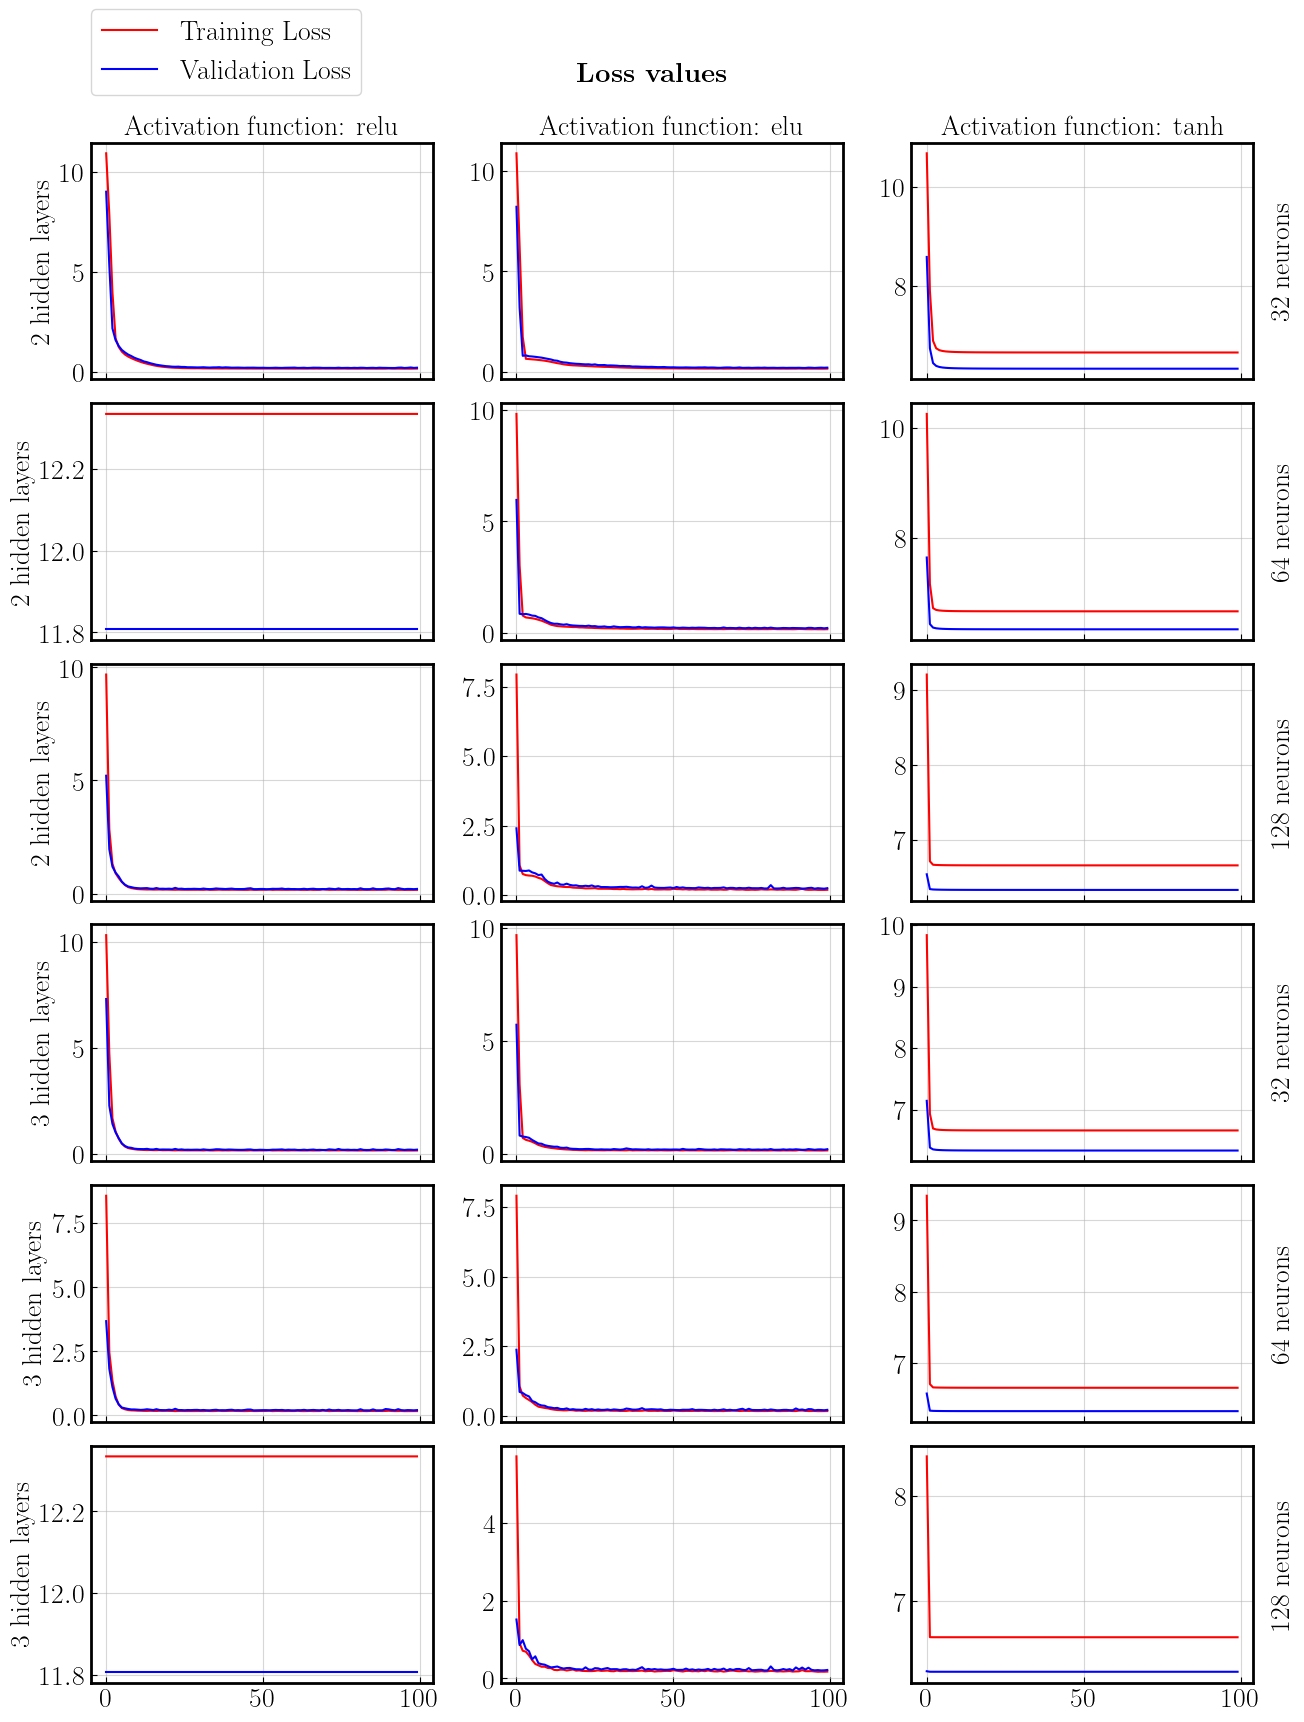

In [20]:
# all losses visualization
fig, axs = plt.subplots(l_lay*l_neu, l_act, figsize=(15,20), gridspec_kw={'hspace': 0.1})
plt.suptitle(r'\textbf{Loss values}', y=0.92)

for a, act in enumerate(activ) :
    for l, lay in enumerate(layers) :
        for n, neu in enumerate(neurons) :
            axs[l*l_neu+n,a].plot(train_loss_2[a,l,n], c='r', label='Training Loss')
            axs[l*l_neu+n,a].plot(valid_loss_2[a,l,n], c='b', label='Validation Loss')

            if(l*l_neu+n != l_lay*l_neu-1) :
                axs[l*l_neu+n,a].set_xticklabels([])
            axs[l*l_neu+n,0].set_ylabel(str(lay) + ' hidden layers')
            axs[l*l_neu+n,2].yaxis.set_label_position('right')
            axs[l*l_neu+n,2].set_ylabel(str(neu) + ' neurons', labelpad=12)
    axs[0,a].set_title('Activation function: ' + act)

axs[0,0].legend(loc=(0,1.2))

plt.show()

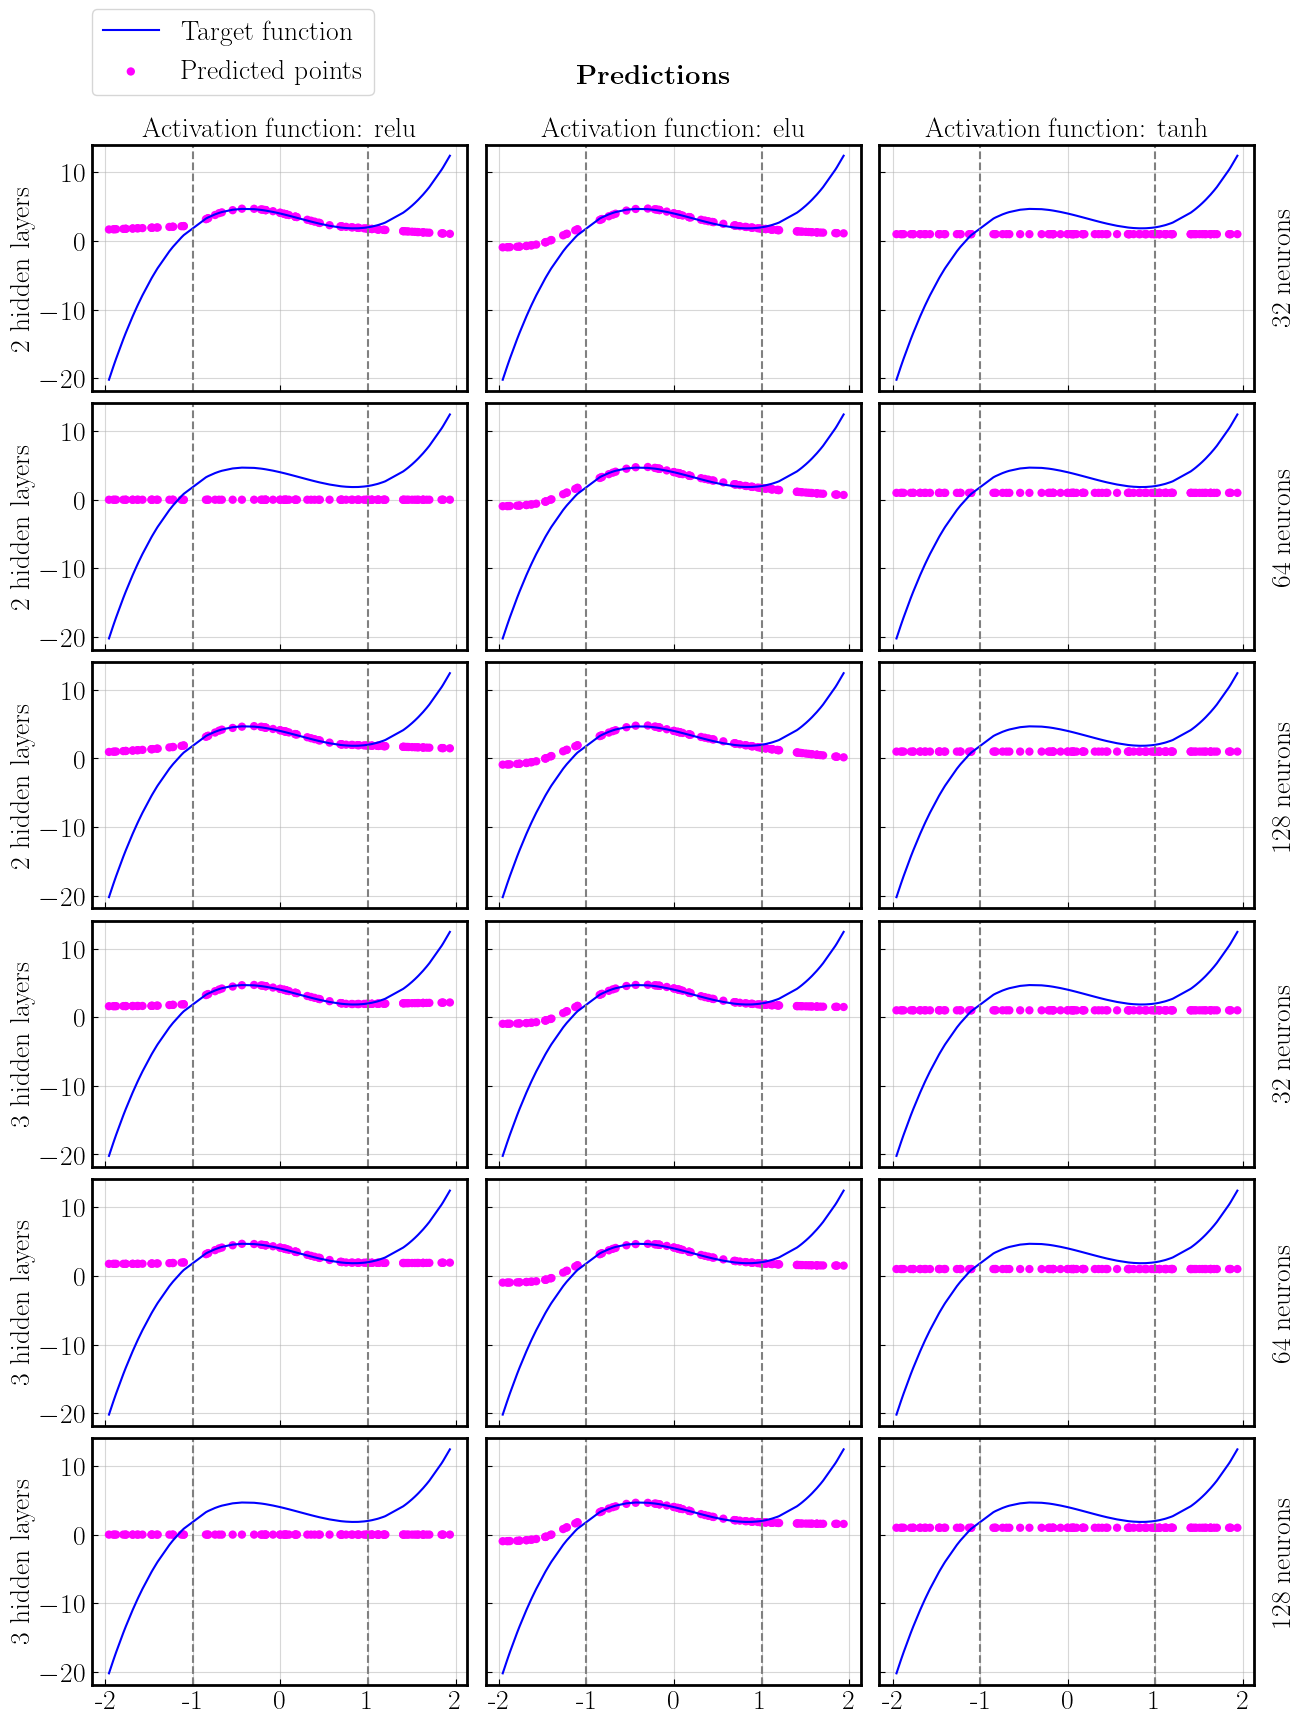

In [21]:
# predicted values
fig, axs = plt.subplots(l_lay*l_neu, l_act, figsize=(15,20), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
plt.suptitle(r'\textbf{Predictions}', y=0.92)

for a, act in enumerate(activ) :
    for l, lay in enumerate(layers) :
        for n, neu in enumerate(neurons) :
            axs[l*l_neu+n,a].plot(x_pred, poly3(x_pred), c='b', label='Target function')
            axs[l*l_neu+n,a].scatter(x_pred, prediction_2[a,l,n], c='magenta', edgecolor='None', label='Predicted points')
            axs[l*l_neu+n,a].axvline(-1, c='gray', ls='--')
            axs[l*l_neu+n,a].axvline(1, c='gray', ls='--')

            axs[l*l_neu+n,a].set_xticklabels([])
            axs[-1,a].set_xticks([-2,-1,0,1,2], ['-2','-1','0','1',2])
            if(a != 0) :
                axs[l*l_neu+n,a].set_yticklabels([])
            axs[l*l_neu+n,0].set_ylabel(str(lay) + ' hidden layers')
            axs[l*l_neu+n,2].yaxis.set_label_position('right')
            axs[l*l_neu+n,2].set_ylabel(str(neu) + ' neurons', labelpad=12)
    axs[0,a].set_title('Activation function: ' + act)

axs[0,0].legend(loc=(0,1.2))

plt.show()

# Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

In [22]:
# target function
def sin2D(x, y) :
    return np.sin(x**2 + y**2)

# training dataset
n_train = 10000
x_train = np.random.uniform(-1.5, 1.5, n_train)
y_train = np.random.uniform(-1.5, 1.5, n_train)
data_train = np.column_stack((x_train, y_train))
z_train = np.random.normal(sin2D(x_train, y_train), sigma)

sigma = 0.4

# validation dataset
n_valid = 1000
x_valid = np.random.uniform(-1.5, 1.5, n_valid)
y_valid = np.random.uniform(-1.5, 1.5, n_valid)
data_valid = np.column_stack((x_valid, y_valid))
z_valid = np.random.normal(sin2D(x_valid, y_valid), sigma)

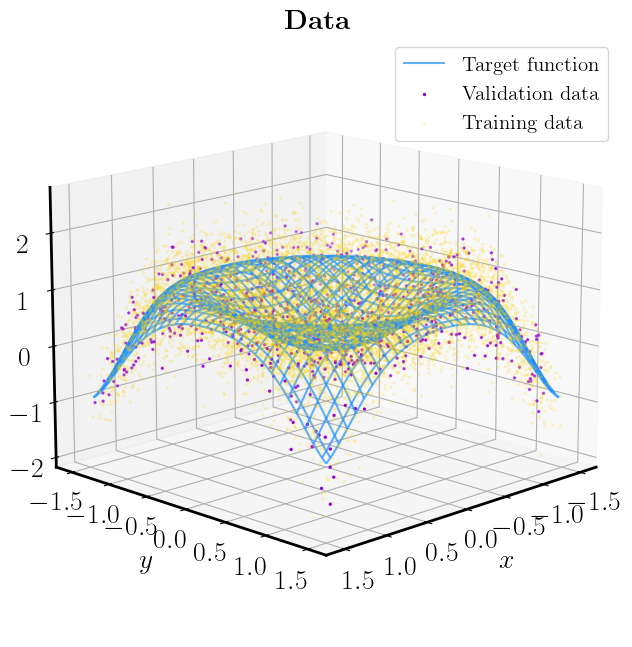

In [23]:
fig = plt.figure(figsize = (6, 6))
ax = Axes3D(fig)
fig.add_axes(ax)

x_surf = np.arange(-1.5, 1.5, 0.05)
y_surf = np.arange(-1.5, 1.5, 0.05)
X_surf, Y_surf = np.meshgrid(x_surf,y_surf)
ax.plot_wireframe(X_surf, Y_surf, sin2D(X_surf, Y_surf), color='dodgerblue', alpha=0.7, label = 'Target function')
ax.scatter(x_valid, y_valid, z_valid, s=2, color='darkviolet', label = 'Validation data')
ax.scatter(x_train, y_train, z_train, s=2, color='gold', alpha=0.15, label = 'Training data')
ax.set_xlabel('$x$', labelpad=10)
ax.set_ylabel('$y$', labelpad=10)
ax.set_zlabel('$z$')
plt.title(r'\textbf{Data}')

ax.legend(fontsize=15)
ax.view_init(15, 45)

plt.show()

In [24]:
# training hyperparams
epochs = 100
act = 'elu'

# model
NN_3_1 = tf.keras.Sequential()

NN_3_1.add(Dense(32, input_shape=(2,), activation=act))
NN_3_1.add(Dense(64, activation=act))
NN_3_1.add(Dense(1, activation=act))

NN_3_1.compile(optimizer='adam', loss='mse', metrics=['mse'])
NN_3_1.summary()

# training
history_3_1 = NN_3_1.fit(x=data_train, y=z_train, batch_size=32, epochs=epochs, shuffle=True, validation_data=(data_valid, z_valid))

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 32)                96        
                                                                 
 dense_128 (Dense)           (None, 64)                2112      
                                                                 
 dense_129 (Dense)           (None, 1)                 65        
                                                                 
Total params: 2273 (8.88 KB)
Trainable params: 2273 (8.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 0.3276 - mse: 0.3276 - val_loss: 0.2917 - val_mse: 0.2917
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 0.3071 - mse: 0.3071 - val_loss: 0.2832 - val_mse: 0.2832
Epoch 3/100
313/313

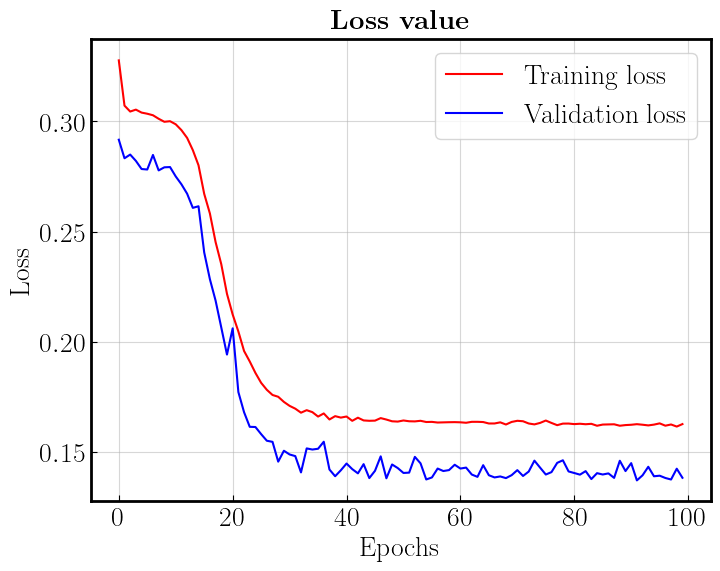

In [25]:
# plotting the loss
plt.plot(history_3_1.history['loss'], c='r', label='Training loss')
plt.plot(history_3_1.history['val_loss'], c='b', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(r'\textbf{Loss value}', pad=8)
plt.legend()
plt.show()

94/94 [==============================] - 0s 1ms/step


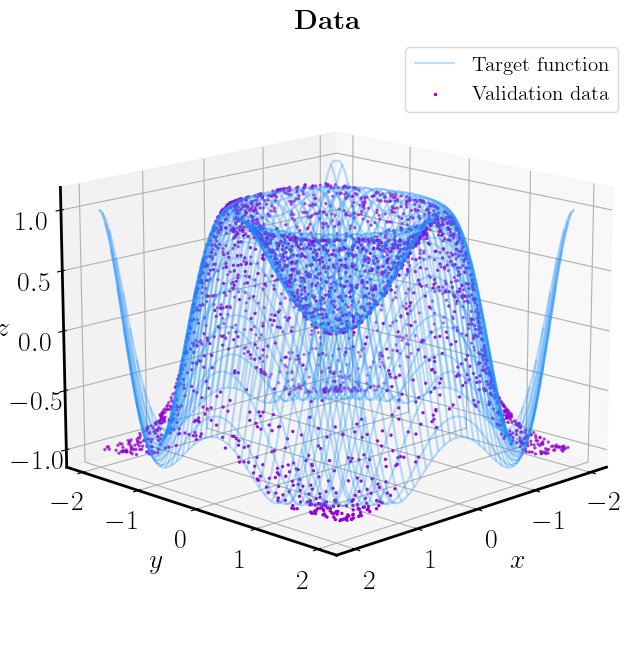

In [26]:
# plotting the prediction
n_pred = 3000
x_pred = np.random.uniform(-2,2,n_pred)
y_pred = np.random.uniform(-2,2,n_pred)
data_pred = np.column_stack((x_pred, y_pred))
z_pred = NN_3_1.predict(data_pred)

fig = plt.figure(figsize = (6, 6))
ax = Axes3D(fig)
fig.add_axes(ax)

x_surf = np.arange(-2, 2, 0.05)
y_surf = np.arange(-2, 2, 0.05)
X_surf, Y_surf = np.meshgrid(x_surf,y_surf)
ax.plot_wireframe(X_surf, Y_surf, sin2D(X_surf, Y_surf), color='dodgerblue', alpha=0.3, label = 'Target function')
ax.scatter(x_pred, y_pred, z_pred, s=2, color='darkviolet', label = 'Validation data')
ax.set_xlabel('$x$', labelpad=10)
ax.set_ylabel('$y$', labelpad=10)
ax.set_zlabel('$z$')
plt.title(r'\textbf{Data}')

ax.legend(fontsize=15)
ax.view_init(15, 45)

plt.show()

In [27]:
# trying to combine different activaion functions
# training hyperparams
epochs = 200

# model
NN_3_2 = tf.keras.Sequential()

NN_3_2.add(Dense(32, input_shape=(2,), activation='elu'))
NN_3_2.add(Dense(64, activation='elu'))
NN_3_2.add(Dense(128, activation='tanh'))
NN_3_2.add(Dense(64, activation='tanh'))
NN_3_2.add(Dense(1, activation='elu'))

NN_3_2.compile(optimizer='adam', loss='mse', metrics=['mse'])
NN_3_2.summary()

# training
history_3_2 = NN_3_2.fit(x=data_train, y=z_train, batch_size=32, epochs=epochs, shuffle=True, validation_data=(data_valid, z_valid))


Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 32)                96        
                                                                 
 dense_131 (Dense)           (None, 64)                2112      
                                                                 
 dense_132 (Dense)           (None, 128)               8320      
                                                                 
 dense_133 (Dense)           (None, 64)                8256      
                                                                 
 dense_134 (Dense)           (None, 1)                 65        
                                                                 
Total params: 18849 (73.63 KB)
Trainable params: 18849 (73.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
313/3

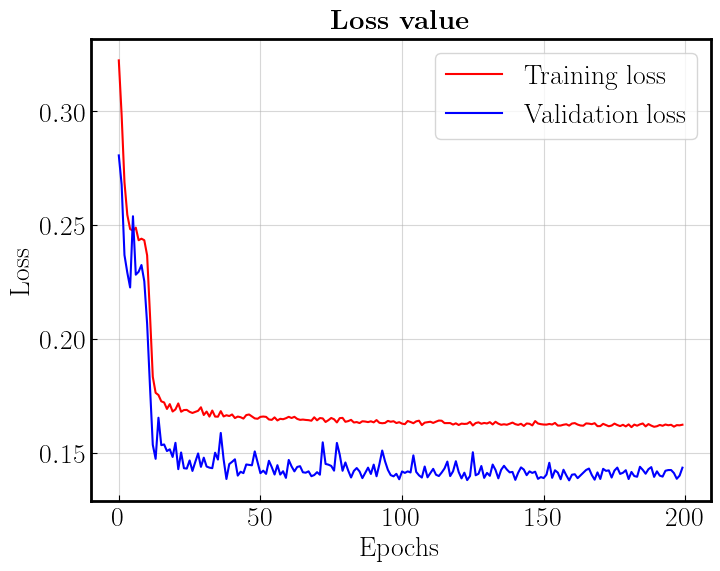

In [28]:
# plotting the loss
plt.plot(history_3_2.history['loss'], c='r', label='Training loss')
plt.plot(history_3_2.history['val_loss'], c='b', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(r'\textbf{Loss value}', pad=8)
plt.legend()
plt.show()

94/94 [==============================] - 0s 1ms/step


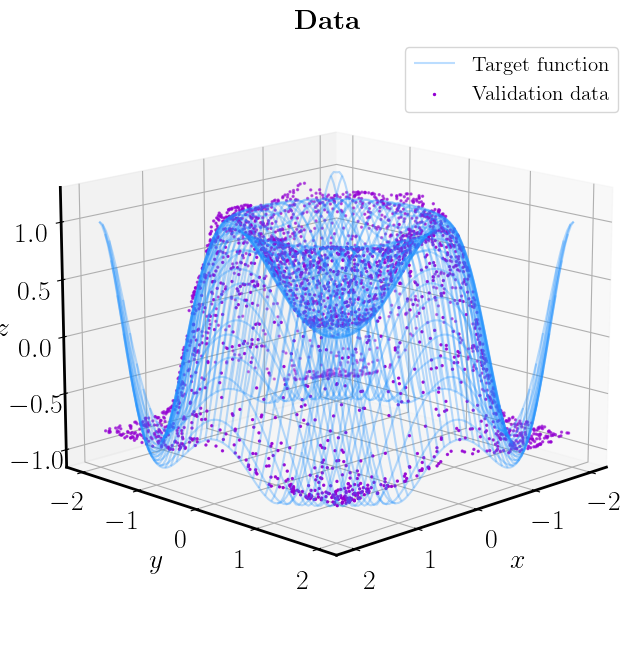

In [29]:
# plotting the prediction
n_pred = 3000
x_pred = np.random.uniform(-2,2,n_pred)
y_pred = np.random.uniform(-2,2,n_pred)
data_pred = np.column_stack((x_pred, y_pred))
z_pred = NN_3_2.predict(data_pred)

fig = plt.figure(figsize = (6, 6))
ax = Axes3D(fig)
fig.add_axes(ax)

x_surf = np.arange(-2, 2, 0.05)
y_surf = np.arange(-2, 2, 0.05)
X_surf, Y_surf = np.meshgrid(x_surf,y_surf)
ax.plot_wireframe(X_surf, Y_surf, sin2D(X_surf, Y_surf), color='dodgerblue', alpha=0.3, label = 'Target function')
ax.scatter(x_pred, y_pred, z_pred, s=2, color='darkviolet', label = 'Validation data')
ax.set_xlabel('$x$', labelpad=10)
ax.set_ylabel('$y$', labelpad=10)
ax.set_zlabel('$z$')
plt.title(r'\textbf{Data}')

ax.legend(fontsize=15)
ax.view_init(15, 45)

plt.show()